In [32]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [34]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

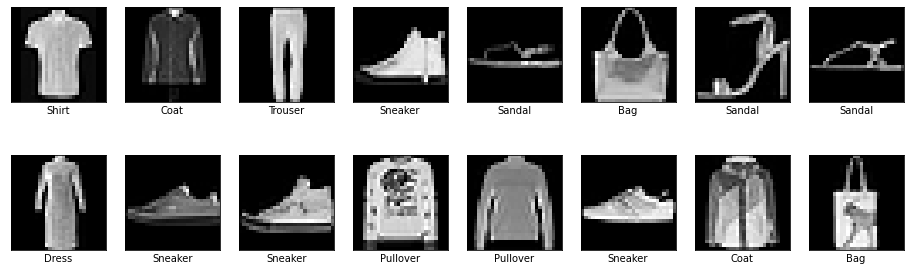

In [35]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

In [36]:
X_train = X_train/255
X_test = X_test/255

In [37]:
X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)
X_train.shape

(60000, 784)

In [38]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [39]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [40]:
num_classes = 10   # число классов
num_features = 784 # число фичей 
 
W = tf.Variable(tf.random.normal([784, 10]), name = 'w')
b = tf.Variable(tf.zeros([10]), name = 'b')
W2 = tf.Variable(tf.random.normal([10, 10]), name = 'w2')
b2 = tf.Variable(tf.zeros([10]), name = 'b2')
# прогнозы

def our_nn(X):
    # ваша модель
    result1 = tf.matmul(X, W) + b 
    result1 = tf.nn.sigmoid(result1)
    
    result2 = tf.matmul(result1, W2) + b2 
    result2 = tf.math.softmax(result2)
    
    return result2

def logloss(p_pred, y_true):
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

def accuracy(y_pred, y_true):
    vector_class_preds = tf.argmax(y_pred, axis=1)
    vector_class_y = tf.argmax(y_true, axis=1)
    tf.reduce_mean(tf.cast(vector_class_preds==vector_class_y, dtype=tf.float32))
    return tf.reduce_mean(tf.cast(vector_class_preds==vector_class_y, dtype=tf.float32))

learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

@tf.function
def model_train(X, Y):
# Считаем градиенты
    with tf.GradientTape() as g:
        pred = our_nn(X)
        loss = logloss(pred, Y)
    
    trainv = [W, W2, b, b2]
    gradients = g.gradient(loss, trainv)
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, trainv))
    

In [41]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

In [42]:
from IPython import display

def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

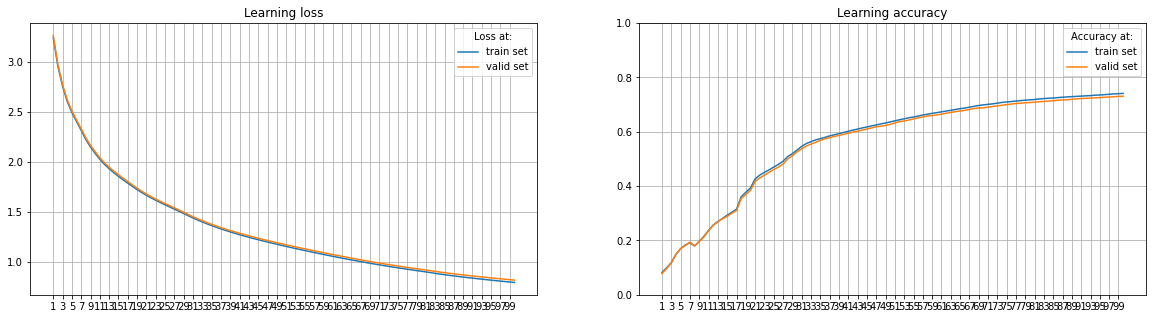

In [43]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        model_train(batch_x, batch_y)
    
    p_train = our_nn(X_train)
    p_test = our_nn(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 